In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from scipy import spatial
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

In [10]:
THREADS = 8

In [11]:
epochs = [5, 25, 50, 250, 500, 1000]
models = [pd.read_pickle(f'/pio/scratch/1/i313924/data/lightfm_data/model_{epochs}_epochs_optimal_hyperparams_categories_item_alpha_0.pkl') for epochs in epochs]
train_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_interactions.npz')
test_interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/5_core_test_interactions.npz')

In [12]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/5_core_dataset_features.pkl')
item_features = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/5_core_features.pkl')

## Utils

In [13]:
def hit_rate(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.any(pdf['rank'] <= k)
        )
    )

def precision(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.sum(pdf['rank'] <= k) / k
        )
    )

def recall(results_pdf, k=50):
    return np.average(
        results_pdf.groupby('reviewerID').progress_apply(
            lambda pdf: np.sum(pdf['rank'] <= k) / len(pdf)
        )
    )

In [14]:
def calculate_metrics(results, user_mapping, item_mapping):
    results = coo_matrix(results)
    results_pdf = pd.DataFrame(
        np.vstack((results.row, results.col, results.data)).T,
        columns=['reviewerID', 'asin', 'rank'],
        dtype=int
    )
    results_pdf['reviewerID'] = results_pdf['reviewerID'].map(user_mapping)
    results_pdf['asin'] = results_pdf['asin'].map(item_mapping)

    return hit_rate(results_pdf), recall(results_pdf), precision(results_pdf)

In [25]:
def analyse_metrics(models, train_interactions, test_interactions, dataset):

    test_precision_scores = []
    test_recall_scores = []
    test_hit_rate_scores = []

    item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
    user_mapping = {v: k for k, v in dataset.mapping()[0].items()}
    for model in tqdm(models):

        results = model.predict_rank(test_interactions, train_interactions, item_features=item_features,num_threads=8)
        hr, r, p = calculate_metrics(results, user_mapping, item_mapping)

        test_hit_rate_scores.append(hr)
        test_recall_scores.append(r)
        test_precision_scores.append(p)

    return test_hit_rate_scores, test_recall_scores, test_precision_scores

In [16]:
def analyse_ABX(path, items_embeddings, pca):
    abx_tests = pd.read_json(path, lines=True)
    A = np.zeros((10000, 240))
    B = np.zeros((10000, 240))
    X = np.zeros((10000, 240))

    for i, test in abx_tests.iterrows():
        A[i, :] = items_embeddings.loc[test["A"]]
        B[i, :] = items_embeddings.loc[test["B"]]
        X[i, :] = items_embeddings.loc[test["X"]]

    dist_A = ((A - X)**2).sum(axis=1)
    dist_B = ((B - X)**2).sum(axis=1)

    cos_dist_A = np.zeros(10000)
    cos_dist_B = np.zeros(10000)

    for i in range(10000):
        cos_dist_A[i] = spatial.distance.cosine(A[i, :], X[i, :])
        cos_dist_B[i] = spatial.distance.cosine(B[i, :], X[i, :])

    if pca is not None:
        pca_A = pca.transform(A)
        pca_B = pca.transform(B)
        pca_X = pca.transform(X)

        dist_pca_A = ((pca_A - pca_X)**2).sum(axis=1)
        dist_pca_B  = ((pca_B - pca_X)**2).sum(axis=1)

        cos_dist_pca_A = np.zeros(10000)
        cos_dist_pca_B = np.zeros(10000)

        for i in range(10000):
            cos_dist_pca_A[i] = spatial.distance.cosine(pca_A[i, :], pca_X[i, :])
            cos_dist_pca_B[i] = spatial.distance.cosine(pca_B[i, :], pca_X[i, :])

    return [(dist_A < dist_B).mean(), (dist_pca_A < dist_pca_B).mean(), ((dist_A < dist_B) == (dist_pca_A < dist_pca_B)).mean()], [(cos_dist_A < cos_dist_B).mean(), (cos_dist_pca_A < cos_dist_pca_B).mean(), ((cos_dist_A < cos_dist_B) == (cos_dist_pca_A < cos_dist_pca_B)).mean()]

In [17]:
def analyse(num_epochs, models, categories, women_ids, men_ids):

    item_embeddings = pd.DataFrame()
    user_embeddings = pd.DataFrame()

    for model in models:

        item_embeddings = pd.concat([item_embeddings, pd.DataFrame(model.get_item_representations(item_features)[1])])
        user_embeddings = pd.concat([user_embeddings, pd.DataFrame(model.user_embeddings)])

    item_pca = PCA(n_components=2)
    item_pca.fit(item_embeddings)
    user_pca = PCA(n_components=2)
    user_pca.fit(user_embeddings)

    print("PCA prepared")

    eucl_scores = []
    cos_scores = []
    women_means = []
    men_means = []

    for i, (epochs, model) in enumerate(zip(num_epochs, models)):

        figure, axis = plt.subplots(1, 2, figsize=(12,6))
        print(f"EPOCH: {epochs}")

        item_mapping = {v: k for k, v in dataset.mapping()[2].items()}

        item_embeddings = pd.DataFrame(model.get_item_representations(item_features)[1])
        user_embeddings = pd.DataFrame(model.user_embeddings)

        reduced_item_embeddings = pd.DataFrame(item_pca.transform(item_embeddings))
        reduced_user_embeddings = pd.DataFrame(user_pca.transform(user_embeddings))

        axis[0].scatter(reduced_user_embeddings[0], reduced_user_embeddings[1], s=0.03)
        axis[0].set_xlim([-1, 1])
        axis[0].set_ylim([-1, 1])

        reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)

        reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))
        reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

        sns.scatterplot(x='0', y='1', data=reduced_item_embeddings, hue='category_1', s=10, ax=axis[1], legend=False)
        figure.show()

        item_embeddings = item_embeddings.rename(index=item_mapping)

        women_mean = item_embeddings.loc[women_ids].mean(axis = 0)
        men_mean = item_embeddings.loc[men_ids].mean(axis = 0)

        women_means.append(women_mean)
        men_means.append(men_mean)

        eucl_score, cos_score = analyse_ABX('/pio/scratch/1/recommender_systems/interim/ABX_tests/5_core.json', item_embeddings, pca = item_pca)

        eucl_scores.append(eucl_score)
        cos_scores.append(cos_score)

    return eucl_scores, cos_scores, women_means, men_means, item_pca

In [18]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [19]:
item_ids = list(dataset.mapping()[2].keys())
women_ids = categories[(categories.category_1 == "Women") & (categories.asin.isin(item_ids))].asin.values
men_ids = categories[(categories.category_1 == "Men") & (categories.asin.isin(item_ids))].asin.values

PCA prepared
EPOCH: 5
EPOCH: 25
EPOCH: 50
EPOCH: 250
EPOCH: 500
EPOCH: 1000


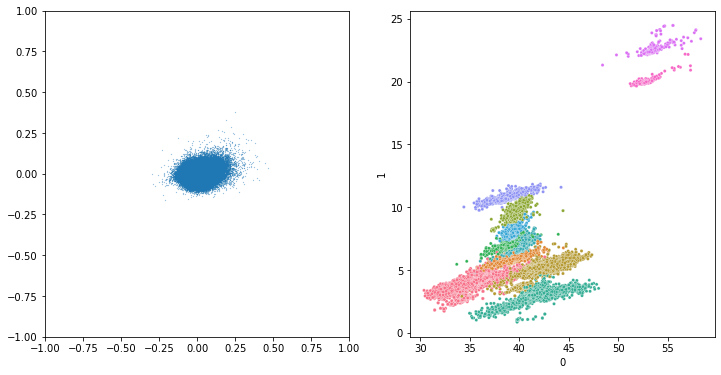

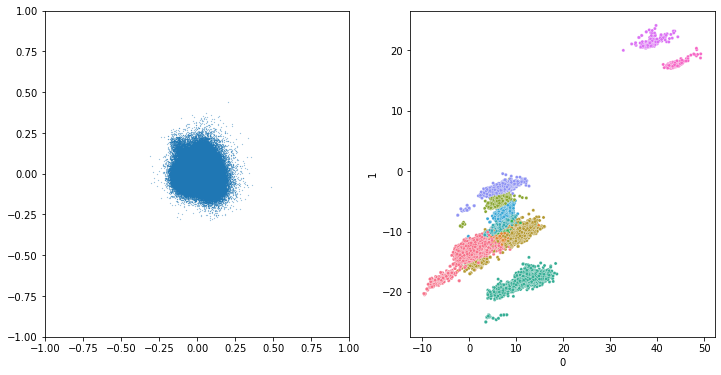

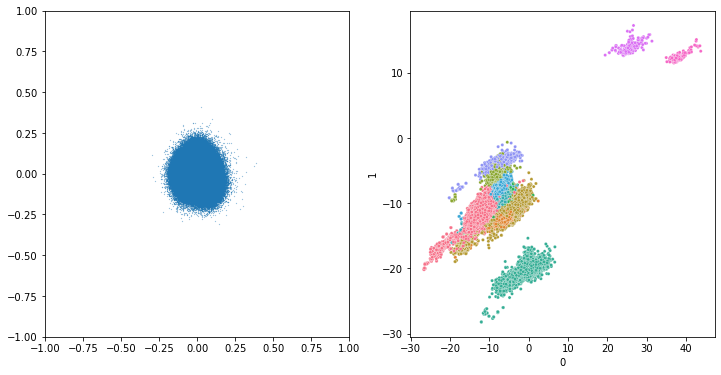

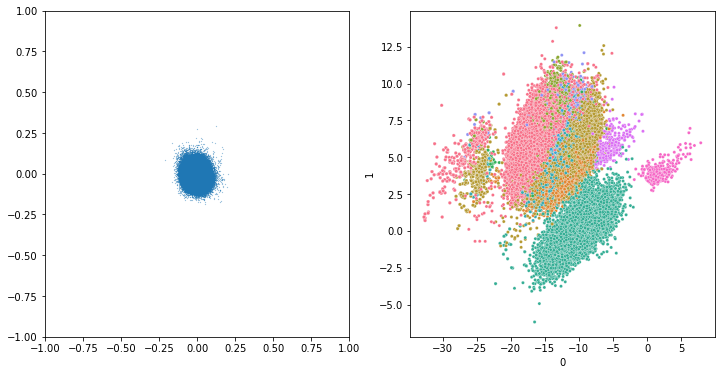

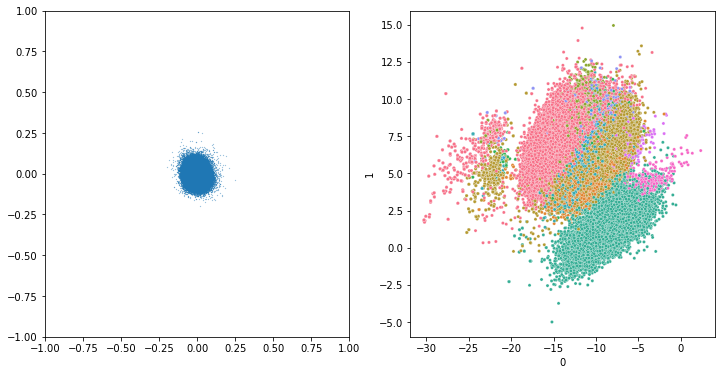

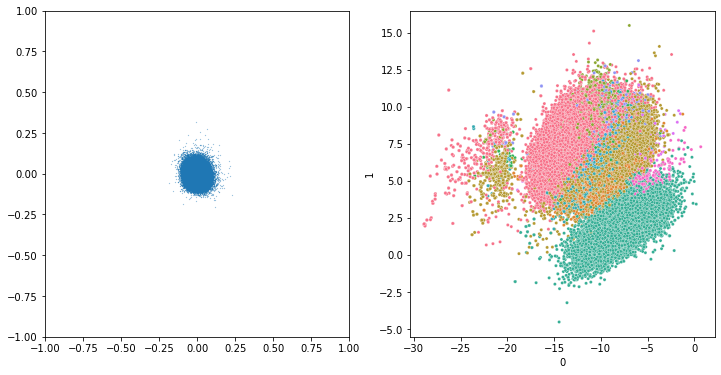

In [20]:
e, c, women_means, men_means, item_pca = analyse(epochs, models, categories, women_ids, men_ids)

Eucl dist


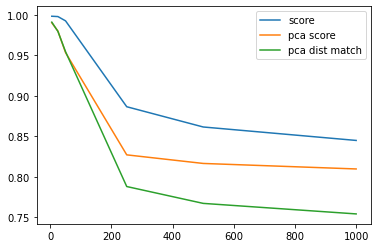

Cos dist


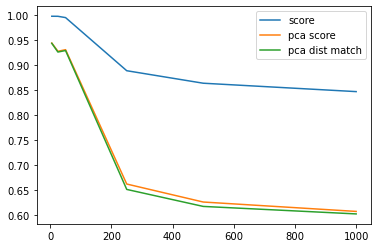

In [21]:
print("Eucl dist")
plt.plot(np.tile(epochs, (3, 1)).T, e)
plt.legend(["score", "pca score", "pca dist match"])
plt.show()
print("Cos dist")
plt.plot(np.tile(epochs, (3, 1)).T, c)
plt.legend(["score", "pca score", "pca dist match"])
plt.show()

In [22]:
e

[[0.9982, 0.9901, 0.9909],
 [0.9978, 0.9799, 0.9795],
 [0.9925, 0.9533, 0.9544],
 [0.8865, 0.8271, 0.788],
 [0.8615, 0.8165, 0.7672],
 [0.8449, 0.8097, 0.7542]]

In [23]:
c

[[0.998, 0.9444, 0.9438],
 [0.9979, 0.9279, 0.9264],
 [0.9953, 0.9311, 0.9294],
 [0.889, 0.6623, 0.6515],
 [0.864, 0.6263, 0.6175],
 [0.8472, 0.6075, 0.6025]]

In [26]:
tqdm.pandas()
test_hit_rate_scores, test_recall_scores, test_precision_scores = analyse_metrics(models, train_interactions, test_interactions, dataset)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
test_recall_scores

[0.11626000000000002, 0.13832, 0.1741, 0.29268, 0.29302, 0.29058]

In [28]:
test_precision_scores

[0.011626,
 0.013831999999999999,
 0.017410000000000002,
 0.029268000000000002,
 0.029302000000000005,
 0.029057999999999997]

In [29]:
test_hit_rate_scores

[0.2001, 0.2568, 0.3123, 0.5903, 0.588, 0.5843]

In [42]:
model = models[-1]
item_embeddings = pd.DataFrame(model.get_item_representations(item_features)[1])
item_mapping = {v: k for k, v in dataset.mapping()[2].items()}
pca = PCA(n_components=2)
pca.fit(item_embeddings)
reduced_item_embeddings = pd.DataFrame(pca.transform(item_embeddings))
reduced_item_embeddings = reduced_item_embeddings.rename(index=item_mapping)
reduced_item_embeddings = reduced_item_embeddings.join(categories.set_index('asin'))
reduced_item_embeddings.columns = ['0', '1', 'category_1', 'category_2']

In [43]:
reduced_item_embeddings.category_1.value_counts()

Women                                120759
Men                                   56380
Novelty & More                        18989
Girls                                 13115
Costumes & Accessories                 7832
Baby                                   7532
Luggage & Travel Gear                  7524
Boys                                   7392
Shoe, Jewelry & Watch Accessories      2926
Uniforms, Work & Safety                 349
Traditional & Cultural Wear             289
Name: category_1, dtype: int64

<AxesSubplot:xlabel='0', ylabel='1'>

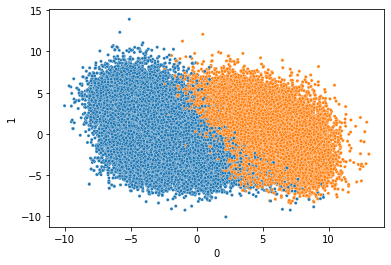

In [44]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10, legend=False)

<AxesSubplot:xlabel='0', ylabel='1'>

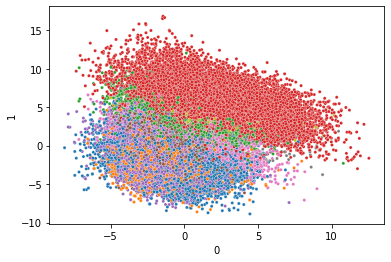

In [45]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[~reduced_item_embeddings['category_1'].isin(['Women', 'Men'])], hue='category_1', s=10, legend=False)

<AxesSubplot:xlabel='0', ylabel='1'>

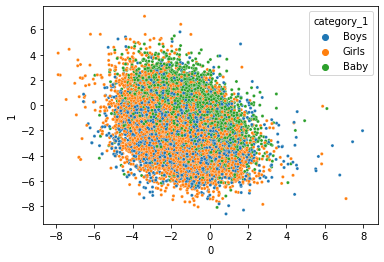

In [46]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Boys', 'Girls', 'Baby'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

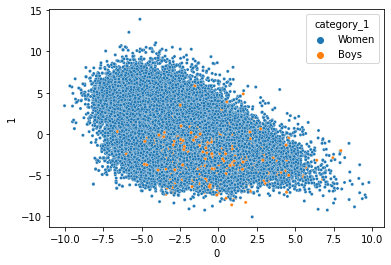

In [47]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Boys', 'Women'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

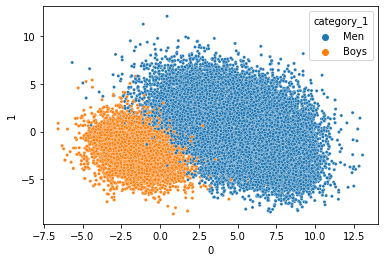

In [48]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Boys', 'Men'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

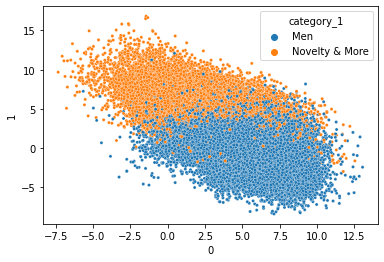

In [49]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Novelty & More', 'Men'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

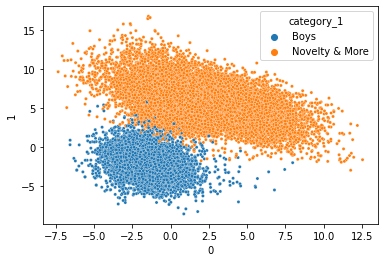

In [50]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Novelty & More', 'Boys'])], hue='category_1', s=10, legend=True)

<AxesSubplot:xlabel='0', ylabel='1'>

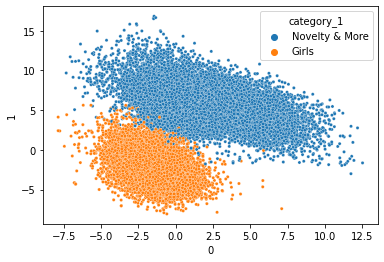

In [51]:
sns.scatterplot(x='0', y='1', data=reduced_item_embeddings[reduced_item_embeddings['category_1'].isin(['Novelty & More', 'Girls'])], hue='category_1', s=10, legend=True)